In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
import xgboost
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,roc_curve, auc
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from spicy import interp
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler
df=pd.read_csv("./heart_statlog_cleveland_hungary_final.csv")

In [2]:
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [3]:
#rectifying inaccuracies
#df.loc[df['age'] > 130, 'age'] = df['age'].median()

In [4]:
Q1 = df['cholesterol'].quantile(0.25)
Q3 = df['cholesterol'].quantile(0.75)
IQR = Q3 - Q1

# managing outliers
outliers = df[(df['cholesterol'] < (Q1 - 1.5 * IQR)) | (df['cholesterol'] > (Q3 + 1.5 * IQR))]
print(outliers)


      age  sex  chest pain type  resting bp s  cholesterol  \
28     53    0                2           113          468   
30     53    1                3           145          518   
69     44    1                4           150          412   
76     32    1                4           118          529   
103    40    1                4           120          466   
...   ...  ...              ...           ...          ...   
935    65    0                3           140          417   
1008   63    0                4           150          407   
1039   67    0                3           115          564   
1060   62    0                4           140          394   
1068   56    0                4           134          409   

      fasting blood sugar  resting ecg  max heart rate  exercise angina  \
28                      0            0             127                0   
30                      0            0             130                0   
69                      0     

In [5]:
# Data transformation
# Data balancing
# Data normalization
from sklearn.preprocessing import StandardScaler
y=df["target"]
X=df.drop(columns=["target"])
X_features=df.drop(columns=["target"])
scaleX=StandardScaler().fit_transform(X_features)
X=pd.DataFrame(data=scaleX,columns=X_features.columns)

In [6]:
#CNN-LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,BatchNormalization,LSTM,Dropout
from eli5.sklearn import PermutationImportance
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import History
def cnnlstm():
    model = Sequential()

    # 1. 第一個 Convolution layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(11, 1)))
    # 2. Max Pooling layer
    model.add(MaxPooling1D(pool_size=2))
    # 3. 第二個 Convolution layer
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    # 4. Batch Normalization
    model.add(BatchNormalization())
    # 5. Max Pooling layer
    model.add(MaxPooling1D(pool_size=2))
    # 6. LSTM 層
    model.add(LSTM(units=64 , return_sequences=False))  # 可以調整 return_sequences
    # 7. Batch Normalization
    model.add(BatchNormalization())
    # 8. Flatten
    model.add(Flatten())
    # 9. Dropout
    model.add(Dropout(0.5))  # dropout 比例可以微調
    # 10. Fully Connected
    model.add(Dense(64, activation='relu'))
    # 11. Output Layer
    model.add(Dense(1, activation='sigmoid'))  # 二分類用 sigmoid，多分類可換 softmax

    # 編譯模型
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 顯示模型架構
    model.summary()
    return model

In [7]:
class KerasClassifierWrapper2:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=100, batch_size=64, verbose=2)

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def predict_proba(self, X):
        return self.model.predict(X)
    
def plot_graphs(history, metric, fold):
    plt.figure()
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.title(f'{metric.capitalize()} over Epochs - Fold {fold+1}')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 128)            24704     
                                                                 
 batch_normalization (BatchN  (None, 2, 128)           512       
 ormalization)                                                   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                        

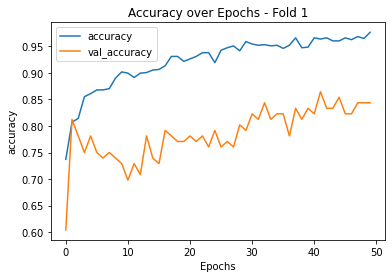

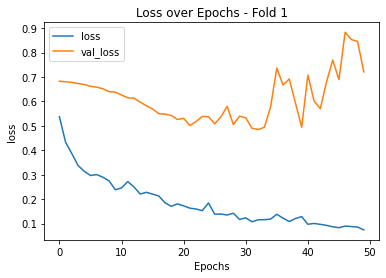

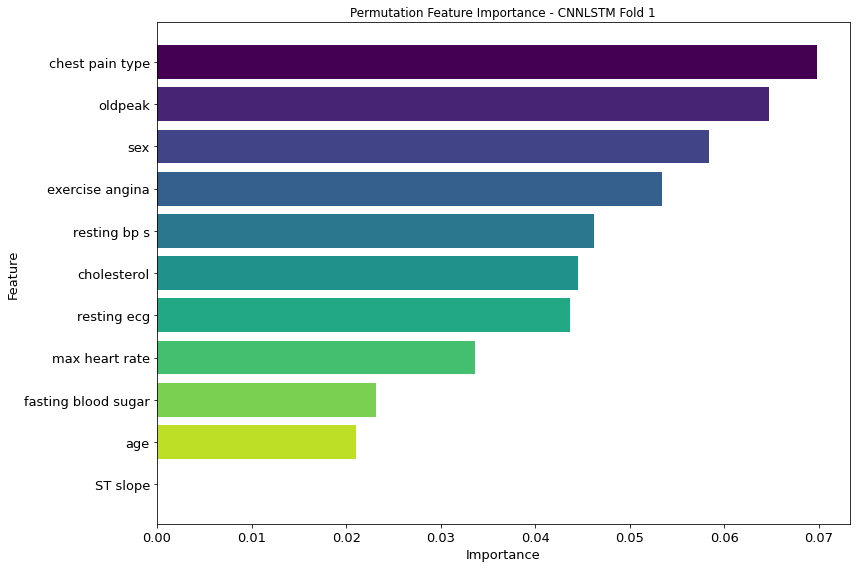

Classification Report for fold 1:
{'Class 0': {'precision': '0.8857', 'recall': '0.8230', 'f1-score': '0.8532', 'support': '113.0000'}, 'Class 1': {'precision': '0.8496', 'recall': '0.9040', 'f1-score': '0.8760', 'support': '125.0000'}, 'accuracy': '0.8655', 'macro avg': {'precision': '0.8677', 'recall': '0.8635', 'f1-score': '0.8646', 'support': '238.0000'}, 'weighted avg': {'precision': '0.8668', 'recall': '0.8655', 'f1-score': '0.8652', 'support': '238.0000'}}


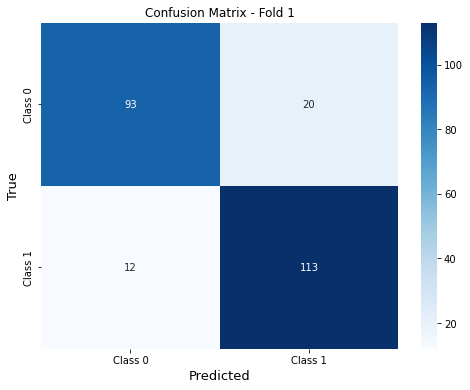

Epoch 1/50
14/14 - 0s - loss: 0.1961 - accuracy: 0.9463 - val_loss: 0.6821 - val_accuracy: 0.8333 - 130ms/epoch - 9ms/step
Epoch 2/50
14/14 - 0s - loss: 0.2095 - accuracy: 0.9346 - val_loss: 0.6471 - val_accuracy: 0.8438 - 94ms/epoch - 7ms/step
Epoch 3/50
14/14 - 0s - loss: 0.2124 - accuracy: 0.9299 - val_loss: 0.4319 - val_accuracy: 0.8646 - 55ms/epoch - 4ms/step
Epoch 4/50
14/14 - 0s - loss: 0.1621 - accuracy: 0.9369 - val_loss: 0.4549 - val_accuracy: 0.8438 - 54ms/epoch - 4ms/step
Epoch 5/50
14/14 - 0s - loss: 0.1405 - accuracy: 0.9474 - val_loss: 0.4240 - val_accuracy: 0.8646 - 58ms/epoch - 4ms/step
Epoch 6/50
14/14 - 0s - loss: 0.1263 - accuracy: 0.9521 - val_loss: 0.4095 - val_accuracy: 0.8750 - 63ms/epoch - 5ms/step
Epoch 7/50
14/14 - 0s - loss: 0.1010 - accuracy: 0.9650 - val_loss: 0.4736 - val_accuracy: 0.8854 - 68ms/epoch - 5ms/step
Epoch 8/50
14/14 - 0s - loss: 0.1045 - accuracy: 0.9673 - val_loss: 0.4442 - val_accuracy: 0.8958 - 113ms/epoch - 8ms/step
Epoch 9/50
14/14 - 0s 

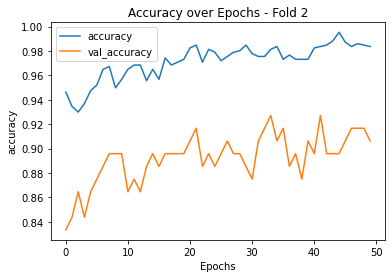

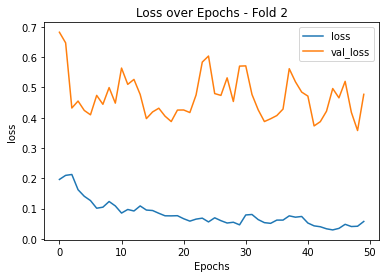

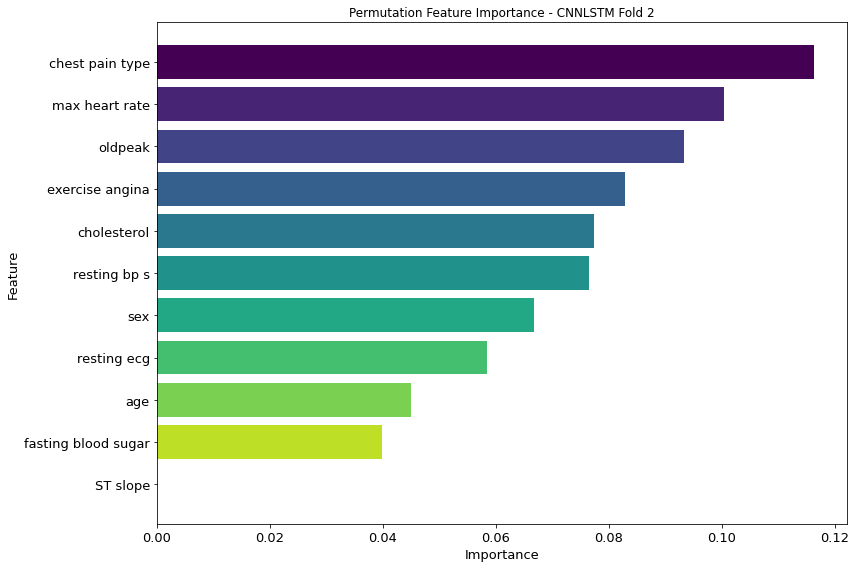

Classification Report for fold 2:
{'Class 0': {'precision': '0.8947', 'recall': '0.9107', 'f1-score': '0.9027', 'support': '112.0000'}, 'Class 1': {'precision': '0.9194', 'recall': '0.9048', 'f1-score': '0.9120', 'support': '126.0000'}, 'accuracy': '0.9076', 'macro avg': {'precision': '0.9070', 'recall': '0.9077', 'f1-score': '0.9073', 'support': '238.0000'}, 'weighted avg': {'precision': '0.9078', 'recall': '0.9076', 'f1-score': '0.9076', 'support': '238.0000'}}


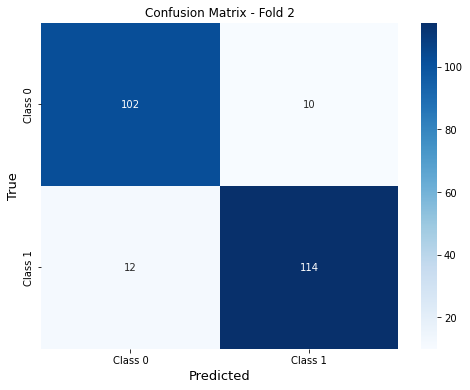

Epoch 1/50
14/14 - 0s - loss: 0.2164 - accuracy: 0.9416 - val_loss: 0.2961 - val_accuracy: 0.8958 - 98ms/epoch - 7ms/step
Epoch 2/50
14/14 - 0s - loss: 0.1604 - accuracy: 0.9381 - val_loss: 0.3132 - val_accuracy: 0.9167 - 88ms/epoch - 6ms/step
Epoch 3/50
14/14 - 0s - loss: 0.1160 - accuracy: 0.9533 - val_loss: 0.1915 - val_accuracy: 0.9479 - 80ms/epoch - 6ms/step
Epoch 4/50
14/14 - 0s - loss: 0.1003 - accuracy: 0.9685 - val_loss: 0.2503 - val_accuracy: 0.9375 - 60ms/epoch - 4ms/step
Epoch 5/50
14/14 - 0s - loss: 0.1087 - accuracy: 0.9498 - val_loss: 0.1885 - val_accuracy: 0.9375 - 62ms/epoch - 4ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0822 - accuracy: 0.9720 - val_loss: 0.1797 - val_accuracy: 0.9479 - 68ms/epoch - 5ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0883 - accuracy: 0.9626 - val_loss: 0.1995 - val_accuracy: 0.9271 - 105ms/epoch - 7ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0612 - accuracy: 0.9778 - val_loss: 0.2395 - val_accuracy: 0.9167 - 106ms/epoch - 8ms/step
Epoch 9/50
14/14 - 0s 

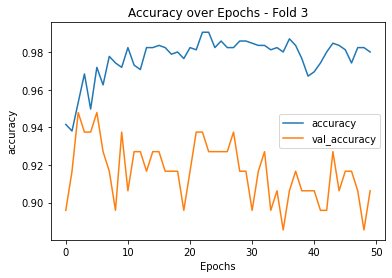

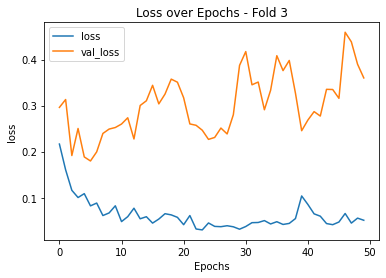

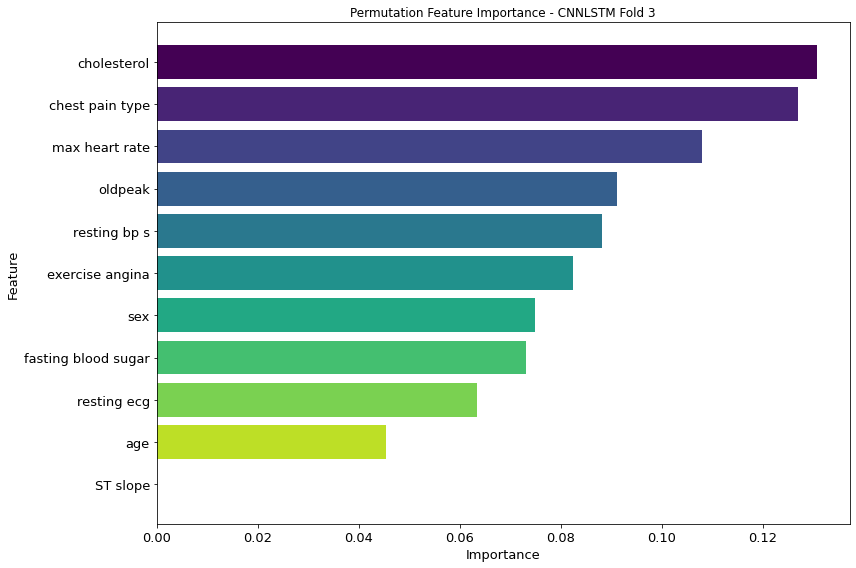

Classification Report for fold 3:
{'Class 0': {'precision': '0.9217', 'recall': '0.9464', 'f1-score': '0.9339', 'support': '112.0000'}, 'Class 1': {'precision': '0.9512', 'recall': '0.9286', 'f1-score': '0.9398', 'support': '126.0000'}, 'accuracy': '0.9370', 'macro avg': {'precision': '0.9365', 'recall': '0.9375', 'f1-score': '0.9368', 'support': '238.0000'}, 'weighted avg': {'precision': '0.9373', 'recall': '0.9370', 'f1-score': '0.9370', 'support': '238.0000'}}


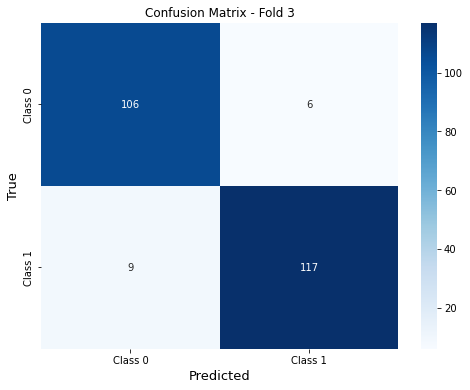

Epoch 1/50
14/14 - 0s - loss: 0.1114 - accuracy: 0.9650 - val_loss: 0.4130 - val_accuracy: 0.9062 - 102ms/epoch - 7ms/step
Epoch 2/50
14/14 - 0s - loss: 0.1024 - accuracy: 0.9708 - val_loss: 0.3835 - val_accuracy: 0.9062 - 92ms/epoch - 7ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0467 - accuracy: 0.9813 - val_loss: 0.4714 - val_accuracy: 0.9167 - 58ms/epoch - 4ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0465 - accuracy: 0.9825 - val_loss: 0.4239 - val_accuracy: 0.9167 - 63ms/epoch - 5ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0582 - accuracy: 0.9755 - val_loss: 0.5221 - val_accuracy: 0.9271 - 62ms/epoch - 4ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0480 - accuracy: 0.9801 - val_loss: 0.5642 - val_accuracy: 0.9167 - 116ms/epoch - 8ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0547 - accuracy: 0.9755 - val_loss: 0.4778 - val_accuracy: 0.9271 - 75ms/epoch - 5ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0303 - accuracy: 0.9918 - val_loss: 0.3756 - val_accuracy: 0.9375 - 61ms/epoch - 4ms/step
Epoch 9/50
14/14 - 0s 

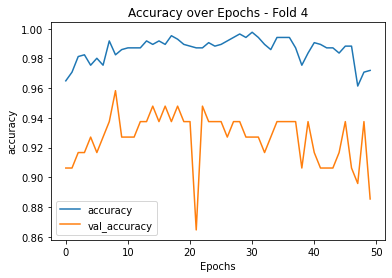

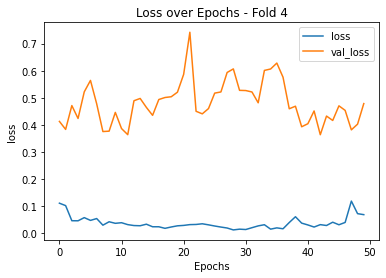

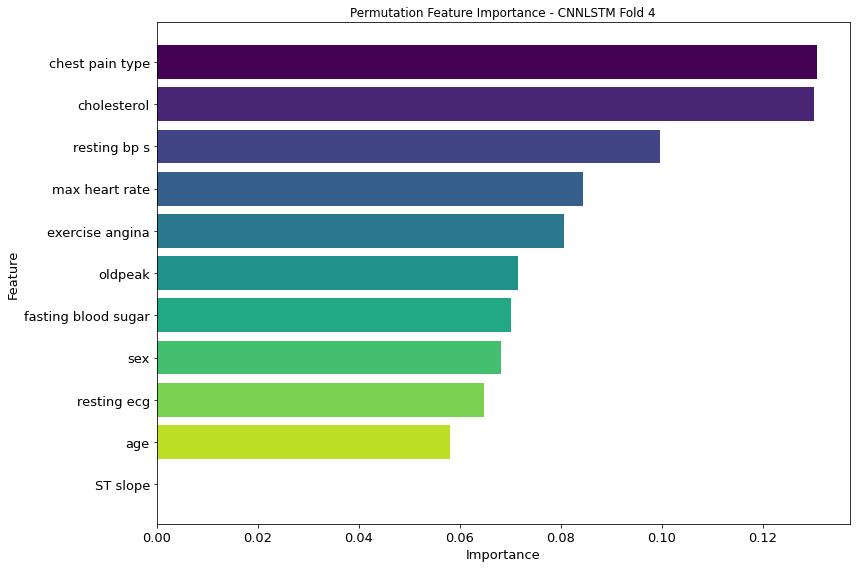

Classification Report for fold 4:
{'Class 0': {'precision': '0.9894', 'recall': '0.8304', 'f1-score': '0.9029', 'support': '112.0000'}, 'Class 1': {'precision': '0.8681', 'recall': '0.9921', 'f1-score': '0.9259', 'support': '126.0000'}, 'accuracy': '0.9160', 'macro avg': {'precision': '0.9287', 'recall': '0.9112', 'f1-score': '0.9144', 'support': '238.0000'}, 'weighted avg': {'precision': '0.9251', 'recall': '0.9160', 'f1-score': '0.9151', 'support': '238.0000'}}


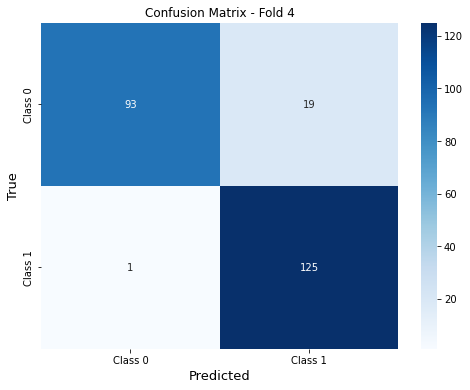

Epoch 1/50
14/14 - 0s - loss: 0.1067 - accuracy: 0.9685 - val_loss: 0.3766 - val_accuracy: 0.9167 - 127ms/epoch - 9ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0882 - accuracy: 0.9603 - val_loss: 0.2656 - val_accuracy: 0.9479 - 74ms/epoch - 5ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0718 - accuracy: 0.9743 - val_loss: 0.4116 - val_accuracy: 0.9062 - 81ms/epoch - 6ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0651 - accuracy: 0.9696 - val_loss: 0.4799 - val_accuracy: 0.9167 - 76ms/epoch - 5ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0838 - accuracy: 0.9731 - val_loss: 0.3620 - val_accuracy: 0.9167 - 88ms/epoch - 6ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0365 - accuracy: 0.9883 - val_loss: 0.3666 - val_accuracy: 0.9271 - 116ms/epoch - 8ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0549 - accuracy: 0.9755 - val_loss: 0.4638 - val_accuracy: 0.9167 - 71ms/epoch - 5ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0568 - accuracy: 0.9790 - val_loss: 0.5846 - val_accuracy: 0.9167 - 71ms/epoch - 5ms/step
Epoch 9/50
14/14 - 0s 

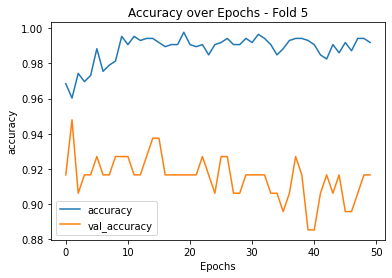

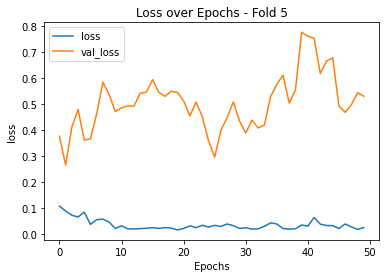

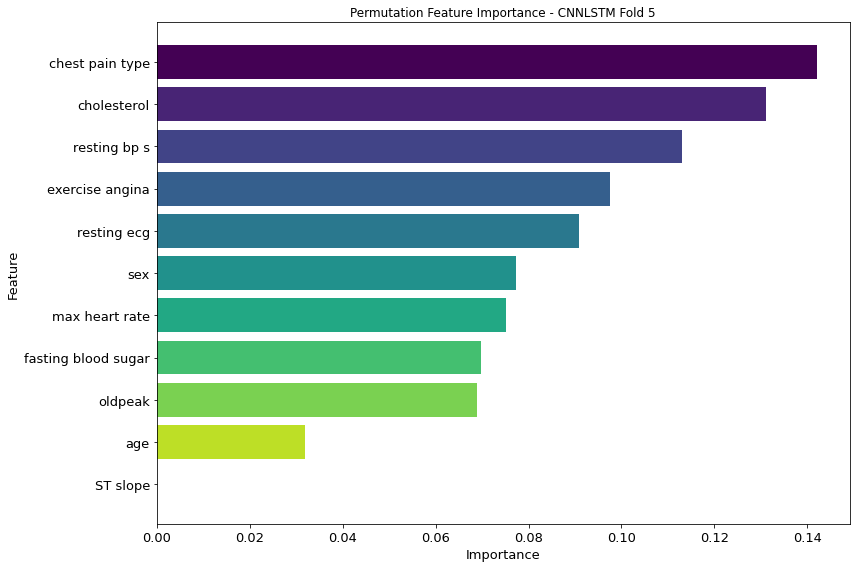

Classification Report for fold 5:
{'Class 0': {'precision': '0.9633', 'recall': '0.9375', 'f1-score': '0.9502', 'support': '112.0000'}, 'Class 1': {'precision': '0.9457', 'recall': '0.9683', 'f1-score': '0.9569', 'support': '126.0000'}, 'accuracy': '0.9538', 'macro avg': {'precision': '0.9545', 'recall': '0.9529', 'f1-score': '0.9535', 'support': '238.0000'}, 'weighted avg': {'precision': '0.9540', 'recall': '0.9538', 'f1-score': '0.9537', 'support': '238.0000'}}


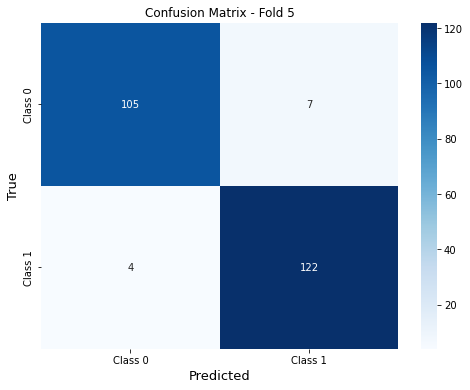

Classification Report for All Folds:
              precision    recall  f1-score   support

     Class 0     0.9292    0.8895    0.9089       561
     Class 1     0.9051    0.9396    0.9220       629

    accuracy                         0.9160      1190
   macro avg     0.9171    0.9145    0.9155      1190
weighted avg     0.9165    0.9160    0.9158      1190



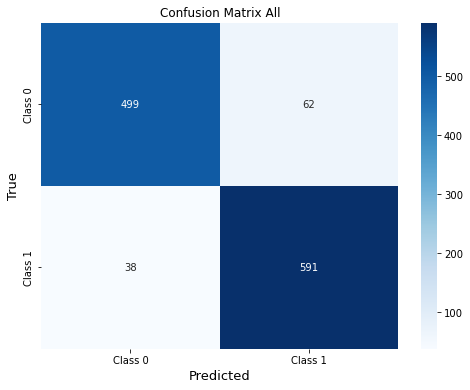

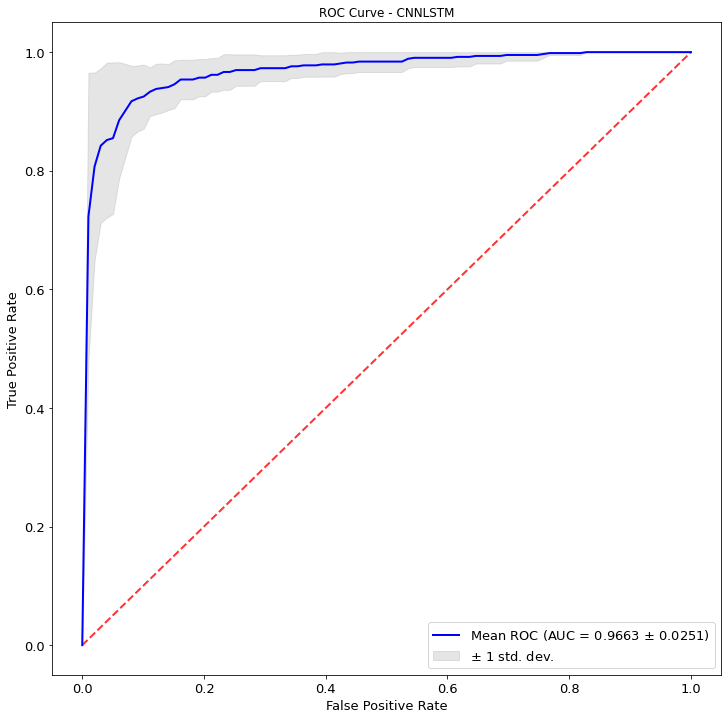

前10筆預測結果：
   true_label  predict_label  predicted_prob
0         0.0            0.0    1.453850e-07
1         1.0            0.0    1.156509e-03
2         0.0            0.0    6.805360e-04
3         1.0            1.0    9.916072e-01
4         0.0            0.0    7.857084e-03
5         0.0            0.0    5.661359e-05
6         0.0            0.0    9.401775e-05
7         0.0            0.0    2.433591e-01
8         1.0            1.0    9.999798e-01
9         0.0            0.0    2.032518e-04


In [8]:
# 繪製模型結構圖
from tensorflow.keras.utils import to_categorical, plot_model
model=cnnlstm()
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True)

from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Reshape the input data
X_reshape = X.values.reshape(len(X.values), 11, 1)

# 用來儲存預測結果與真實標籤
all_true_labels = np.zeros(len(y))
all_predictions = np.zeros(len(y))
all_probas = np.zeros(len(y))

# 之後計算 ROC curve 用
tprs = []
aucs = []
cnnlstmmean_fpr = np.linspace(0, 1, 100)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X_reshape[train_idx], y.iloc[train_idx]
    X_test, y_test = X_reshape[test_idx], y.iloc[test_idx]

    # 訓練模型
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2, validation_split=0.1)

    # 繪圖
    plot_graphs(history, "accuracy", i)
    plot_graphs(history, "loss", i)

    # 預測機率與預測值
    probas_ = model.predict(X_test).ravel()
    predictions = (probas_ >= 0.5).astype(int)

    # 儲存對應位置的預測值與機率
    all_true_labels[test_idx] = y_test
    all_predictions[test_idx] = predictions
    all_probas[test_idx] = probas_

    # ROC 曲線
    fpr, tpr, thresholds = roc_curve(y_test, probas_)
    tprs.append(np.interp(cnnlstmmean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(auc(fpr, tpr))

    # permutation importance
    wrapped_model = KerasClassifierWrapper2(model)
    X_test_2d = X_test.reshape(X_test.shape[0], -1)
    perm = permutation_importance(wrapped_model, X_test_2d, y_test, scoring='accuracy', n_repeats=10, random_state=42)
    importances = perm.importances_mean
    feature_names = X.columns.tolist()
    indices = np.argsort(importances)[::-1]
    sorted_importances = importances[indices]
    sorted_feature_names = [feature_names[i] for i in indices]

    plt.figure(figsize=(12, 8))
    plt.title(f"Permutation Feature Importance - CNNLSTM Fold {i+1}")
    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_importances)))
    plt.barh(range(len(sorted_importances)), sorted_importances, color=colors, align="center")
    plt.yticks(range(len(sorted_importances)), sorted_feature_names, fontsize=13)
    plt.xticks(fontsize=13)
    plt.xlabel('Importance', fontsize=13)
    plt.ylabel('Feature', fontsize=13)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # classification report
    report = classification_report(y_test, predictions, target_names=['Class 0', 'Class 1'], output_dict=True)
    formatted_report = {
        label: {metric: f"{score:.4f}" for metric, score in metrics.items()} if isinstance(metrics, dict) else f"{metrics:.4f}"
        for label, metrics in report.items()
    }
    print(f"Classification Report for fold {i+1}:")
    print(formatted_report)

    # confusion matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix - Fold {i+1}')
    plt.xlabel('Predicted', fontsize=13)
    plt.ylabel('True', fontsize=13)
    plt.show()

# 所有折的總結
print("Classification Report for All Folds:")
print(classification_report(all_true_labels, all_predictions, digits=4, target_names=['Class 0', 'Class 1']))

# 總 confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title(f'Confusion Matrix All')
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('True', fontsize=13)
plt.show()

# 平均 ROC 曲線
plt.figure(figsize=(12, 12))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(cnnlstmmean_fpr, mean_tpr)
std_auc = np.std(aucs)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.plot(cnnlstmmean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
         lw=2)
plt.fill_between(cnnlstmmean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curve - CNNLSTM')
plt.legend(loc="lower right", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

# 印出每筆樣本的預測機率與真實標籤
df_result = pd.DataFrame({
    'true_label': all_true_labels,
    'predict_label': all_predictions,
    'predicted_prob': all_probas
})

print("前10筆預測結果：")
print(df_result.head(10))

# 儲存為 CSV
df_result.to_csv("cnn_lstm_predictions.csv", index=False)


<Figure size 864x864 with 0 Axes>

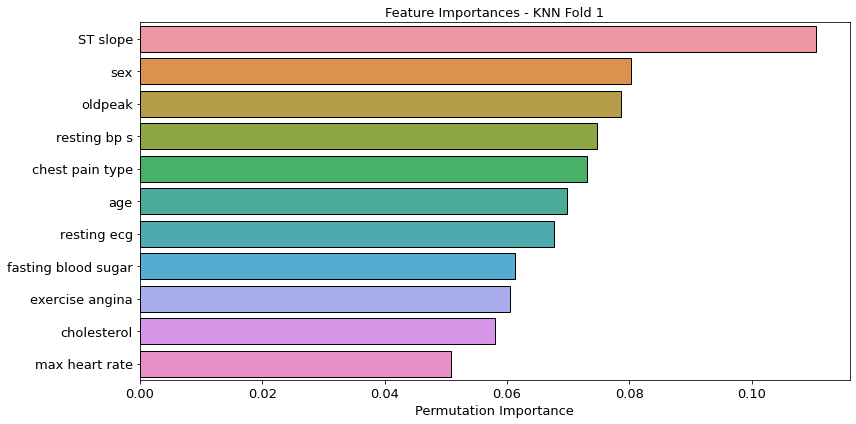

Classification Report for fold 1:
              precision    recall  f1-score   support

           0     0.9464    0.9381    0.9422       113
           1     0.9444    0.9520    0.9482       125

    accuracy                         0.9454       238
   macro avg     0.9454    0.9450    0.9452       238
weighted avg     0.9454    0.9454    0.9454       238



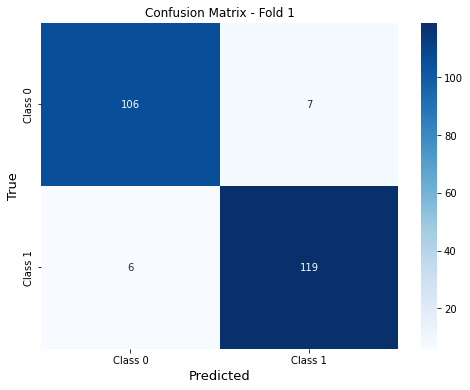

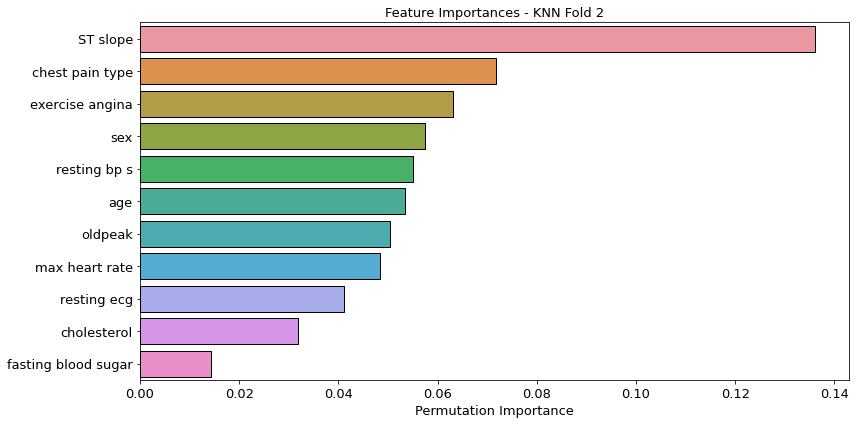

Classification Report for fold 2:
              precision    recall  f1-score   support

           0     0.9273    0.9107    0.9189       112
           1     0.9219    0.9365    0.9291       126

    accuracy                         0.9244       238
   macro avg     0.9246    0.9236    0.9240       238
weighted avg     0.9244    0.9244    0.9243       238



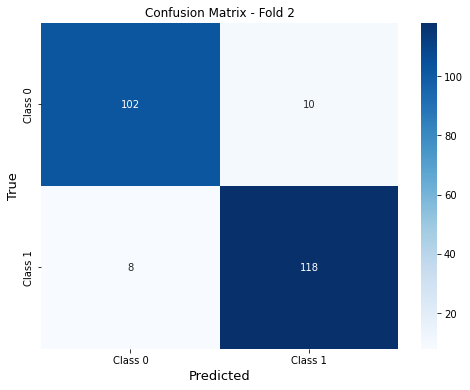

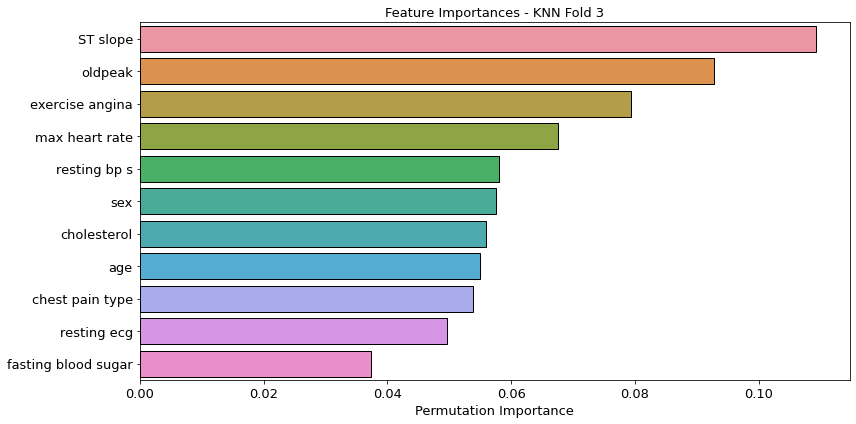

Classification Report for fold 3:
              precision    recall  f1-score   support

           0     0.9439    0.9018    0.9224       112
           1     0.9160    0.9524    0.9339       126

    accuracy                         0.9286       238
   macro avg     0.9300    0.9271    0.9281       238
weighted avg     0.9292    0.9286    0.9285       238



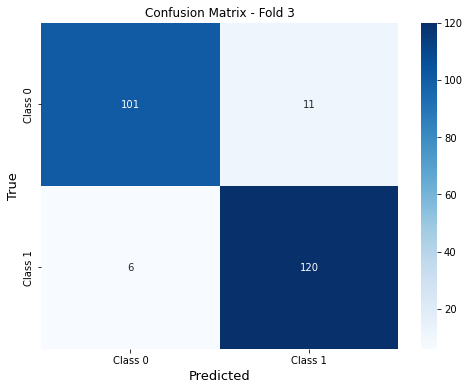

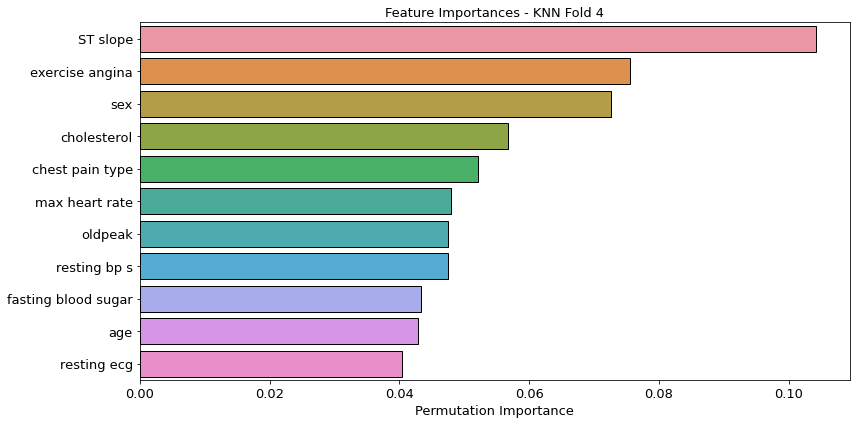

Classification Report for fold 4:
              precision    recall  f1-score   support

           0     0.8860    0.9018    0.8938       112
           1     0.9113    0.8968    0.9040       126

    accuracy                         0.8992       238
   macro avg     0.8986    0.8993    0.8989       238
weighted avg     0.8994    0.8992    0.8992       238



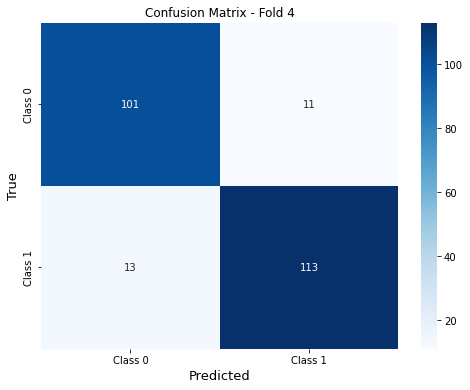

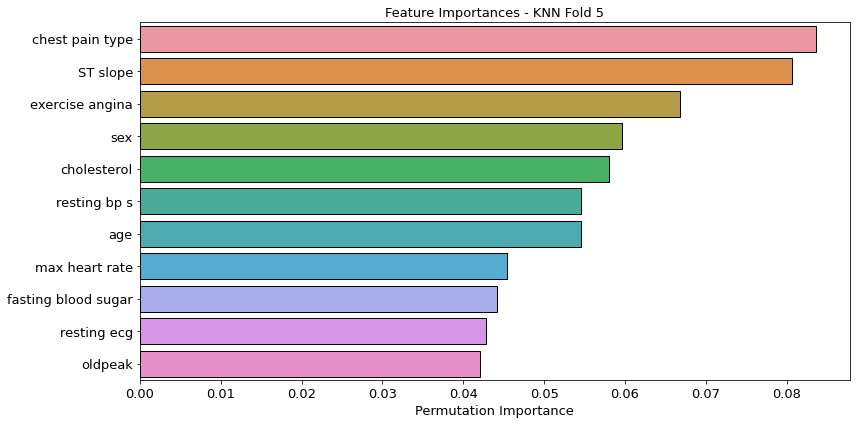

Classification Report for fold 5:
              precision    recall  f1-score   support

           0     0.8981    0.8661    0.8818       112
           1     0.8846    0.9127    0.8984       126

    accuracy                         0.8908       238
   macro avg     0.8914    0.8894    0.8901       238
weighted avg     0.8910    0.8908    0.8906       238



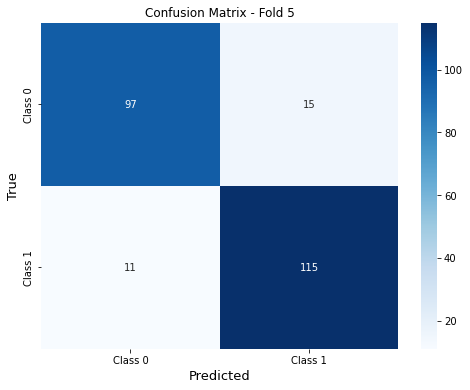

Classification Report for All Folds:
              precision    recall  f1-score   support

     Class 0     0.9201    0.9037    0.9119       561
     Class 1     0.9155    0.9300    0.9227       629

    accuracy                         0.9176      1190
   macro avg     0.9178    0.9169    0.9173      1190
weighted avg     0.9177    0.9176    0.9176      1190



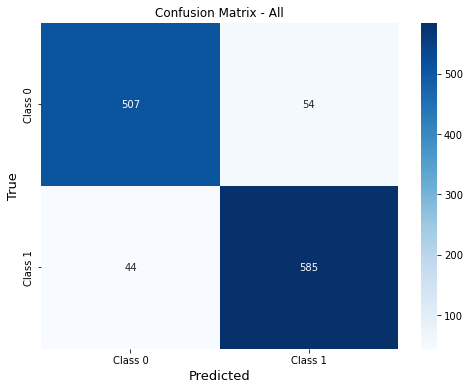

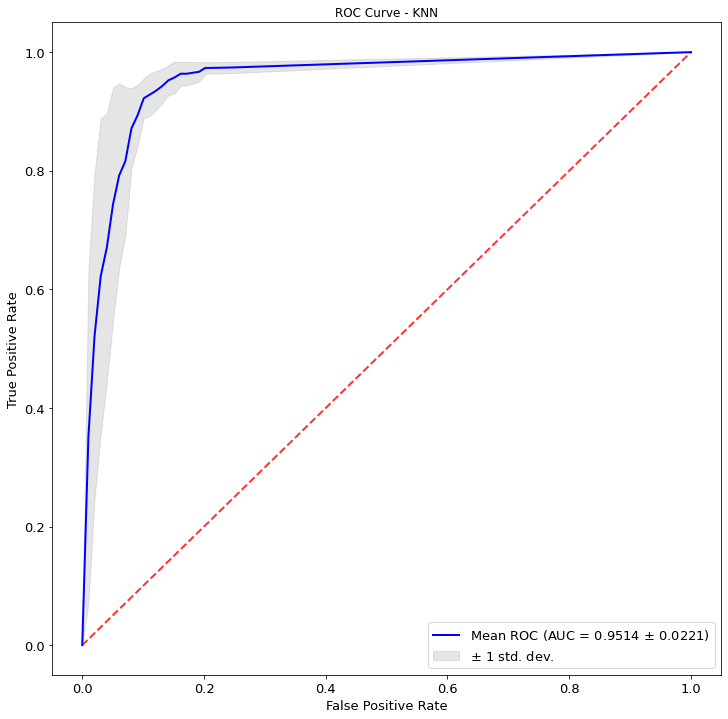

前10筆預測結果：
   true_label  predicted_label  predicted_prob
0         0.0              0.0        0.000000
1         1.0              0.0        0.000000
2         0.0              0.0        0.000000
3         1.0              1.0        0.661152
4         0.0              0.0        0.000000
5         0.0              0.0        0.000000
6         0.0              0.0        0.000000
7         0.0              0.0        0.381636
8         1.0              1.0        0.735147
9         0.0              0.0        0.000000


In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from numpy import interp

# 建立模型
model1 = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto', metric='euclidean')

# 用來儲存預測結果與真實標籤
all_true_labels = np.zeros(len(y))
all_predictions = np.zeros(len(y))
all_probas = np.zeros(len(y))

tprs = []
aucs = []
KNNmean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(12, 12))

# 交叉驗證
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # 模型訓練 + 預測
    model1.fit(X_train, y_train)
    probas_ = model1.predict_proba(X_test)
    predictions = model1.predict(X_test)

    # 儲存對應位置的預測值與機率
    all_true_labels[test_idx] = y_test
    all_predictions[test_idx] = predictions
    all_probas[test_idx] = probas_[:, 1]
    # permutation importance（針對 test fold）
    perm = permutation_importance(model1, X_test, y_test, n_repeats=10, random_state=42)
    importances = pd.Series(perm.importances_mean, index=X.columns)
    importances.sort_values(ascending=False, inplace=True)

    # 繪製重要性圖
    plt.figure(figsize=(12, 6))
    sns.barplot(x=importances.values, y=importances.index, edgecolor="black")
    plt.xlabel("Permutation Importance", fontsize=13)
    plt.title(f"Feature Importances - KNN Fold {i+1}", fontsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.tight_layout()
    plt.show()

    # ROC 曲線
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(KNNmean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # 每折分類報告
    print(f"Classification Report for fold {i+1}:\n{classification_report(y_test, predictions, digits=4)}")

    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix - Fold {i+1}')
    plt.xlabel('Predicted', fontsize=13)
    plt.ylabel('True', fontsize=13)
    plt.show()

# 所有折總體報告
print("Classification Report for All Folds:")
print(classification_report(all_true_labels, all_predictions, digits=4, target_names=['Class 0', 'Class 1']))

# 總 confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title(f'Confusion Matrix - All')
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('True', fontsize=13)
plt.show()

# 平均 ROC 曲線
plt.figure(figsize=(12, 12))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

KNNmean_tpr = np.mean(tprs, axis=0)
KNNmean_tpr[-1] = 1.0
KNNmean_auc = auc(KNNmean_fpr, KNNmean_tpr)
std_auc = np.std(aucs)
std_tpr = np.std(tprs, axis=0)

tprs_upper = np.minimum(KNNmean_tpr + std_tpr, 1)
tprs_lower = np.maximum(KNNmean_tpr - std_tpr, 0)

plt.plot(KNNmean_fpr, KNNmean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (KNNmean_auc, std_auc),
         lw=2)
plt.fill_between(KNNmean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('ROC Curve - KNN')
plt.legend(loc="lower right", fontsize=13)
plt.show()

# 輸出每筆樣本預測結果與真實標籤
df_result = pd.DataFrame({
    "true_label":all_true_labels,
    "predicted_label": all_predictions,
    "predicted_prob":  all_probas
})

print("前10筆預測結果：")
print(df_result.head(10))

# 儲存
df_result.to_csv("knn_predictions.csv", index=False)


<Figure size 864x864 with 0 Axes>

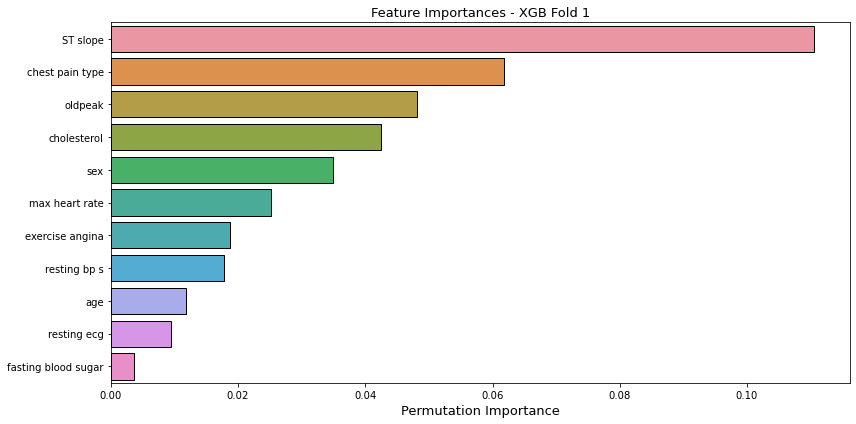

Classification Report for fold 1:
              precision    recall  f1-score   support

           0     0.8938    0.8938    0.8938       113
           1     0.9040    0.9040    0.9040       125

    accuracy                         0.8992       238
   macro avg     0.8989    0.8989    0.8989       238
weighted avg     0.8992    0.8992    0.8992       238




C:\Users\charl\AppData\Local\Temp\ipykernel_16516\199148168.py:51: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(XGBmean_fpr, fpr, tpr))


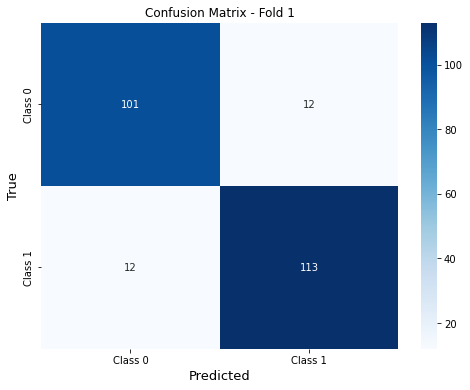

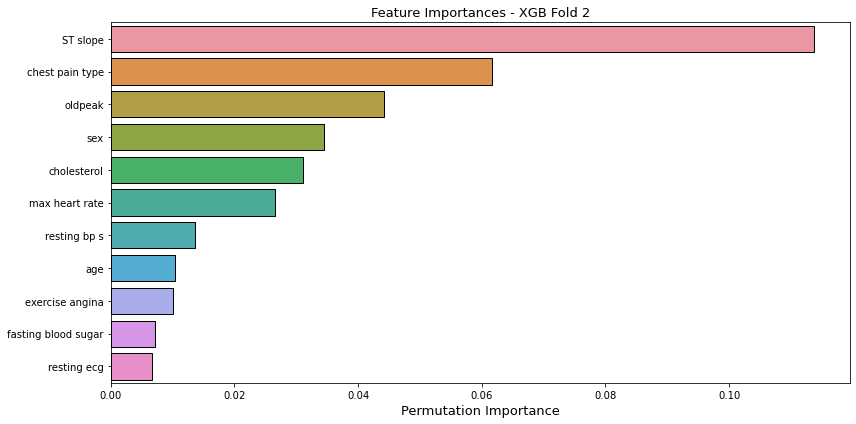

Classification Report for fold 2:
              precision    recall  f1-score   support

           0     0.9009    0.8929    0.8969       112
           1     0.9055    0.9127    0.9091       126

    accuracy                         0.9034       238
   macro avg     0.9032    0.9028    0.9030       238
weighted avg     0.9033    0.9034    0.9033       238




C:\Users\charl\AppData\Local\Temp\ipykernel_16516\199148168.py:51: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(XGBmean_fpr, fpr, tpr))


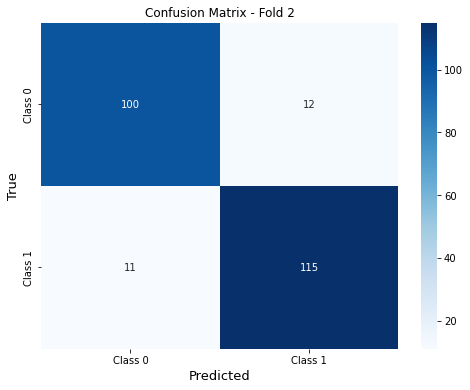

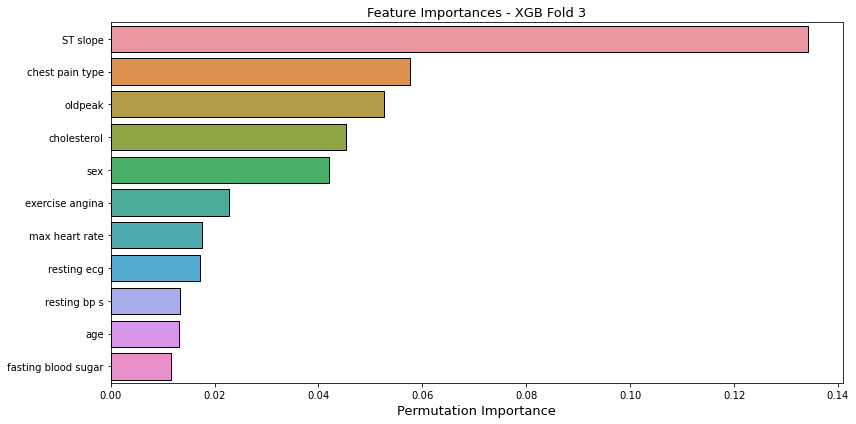

Classification Report for fold 3:
              precision    recall  f1-score   support

           0     0.8772    0.8929    0.8850       112
           1     0.9032    0.8889    0.8960       126

    accuracy                         0.8908       238
   macro avg     0.8902    0.8909    0.8905       238
weighted avg     0.8910    0.8908    0.8908       238




C:\Users\charl\AppData\Local\Temp\ipykernel_16516\199148168.py:51: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(XGBmean_fpr, fpr, tpr))


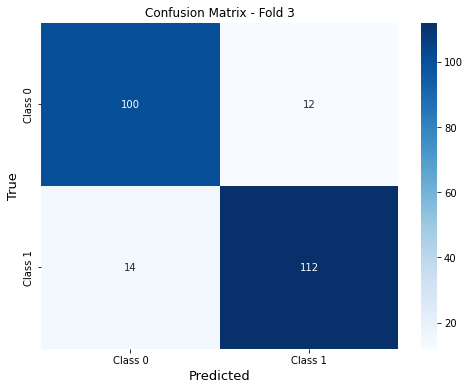

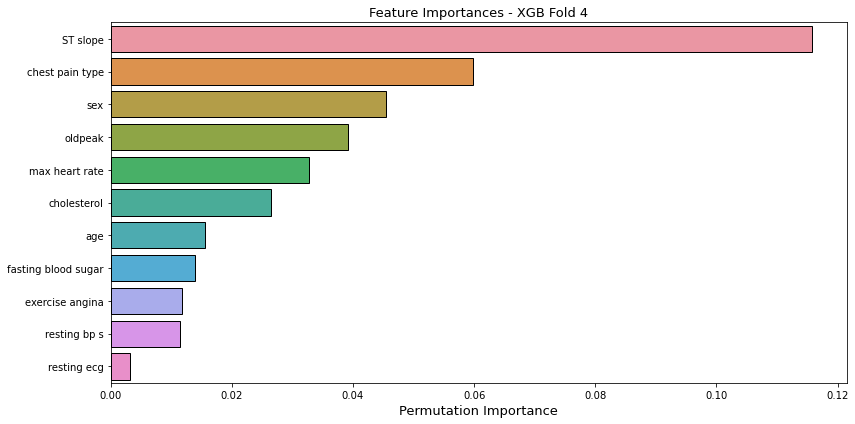

C:\Users\charl\AppData\Local\Temp\ipykernel_16516\199148168.py:51: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(XGBmean_fpr, fpr, tpr))


Classification Report for fold 4:
              precision    recall  f1-score   support

           0     0.8750    0.8750    0.8750       112
           1     0.8889    0.8889    0.8889       126

    accuracy                         0.8824       238
   macro avg     0.8819    0.8819    0.8819       238
weighted avg     0.8824    0.8824    0.8824       238




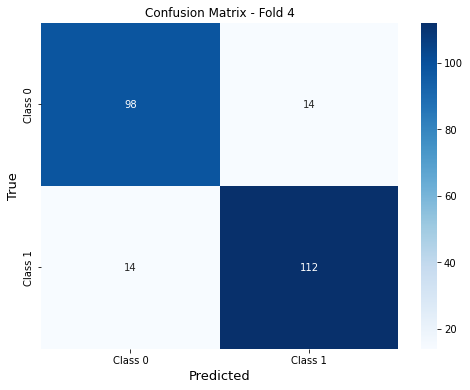

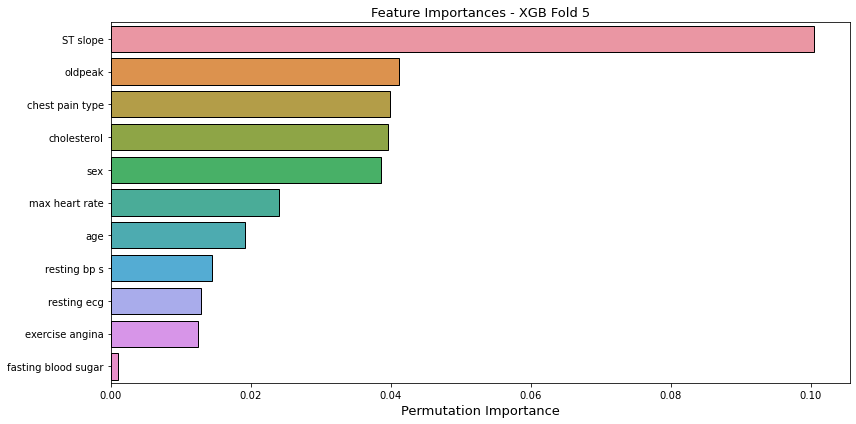

Classification Report for fold 5:
              precision    recall  f1-score   support

           0     0.8716    0.8482    0.8597       112
           1     0.8682    0.8889    0.8784       126

    accuracy                         0.8697       238
   macro avg     0.8699    0.8686    0.8691       238
weighted avg     0.8698    0.8697    0.8696       238




C:\Users\charl\AppData\Local\Temp\ipykernel_16516\199148168.py:51: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(XGBmean_fpr, fpr, tpr))


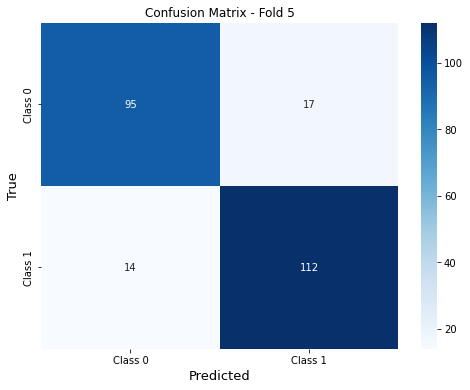

Classification Report for All Folds:
              precision    recall  f1-score   support

     Class 0     0.8837    0.8806    0.8821       561
     Class 1     0.8938    0.8967    0.8952       629

    accuracy                         0.8891      1190
   macro avg     0.8888    0.8886    0.8887      1190
weighted avg     0.8891    0.8891    0.8891      1190



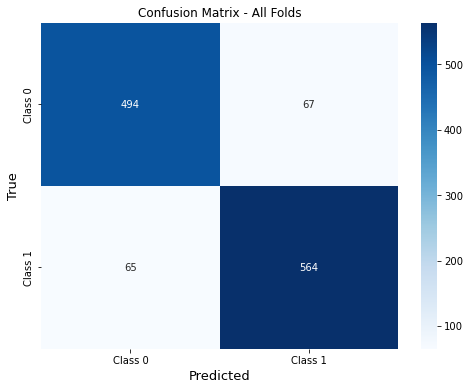

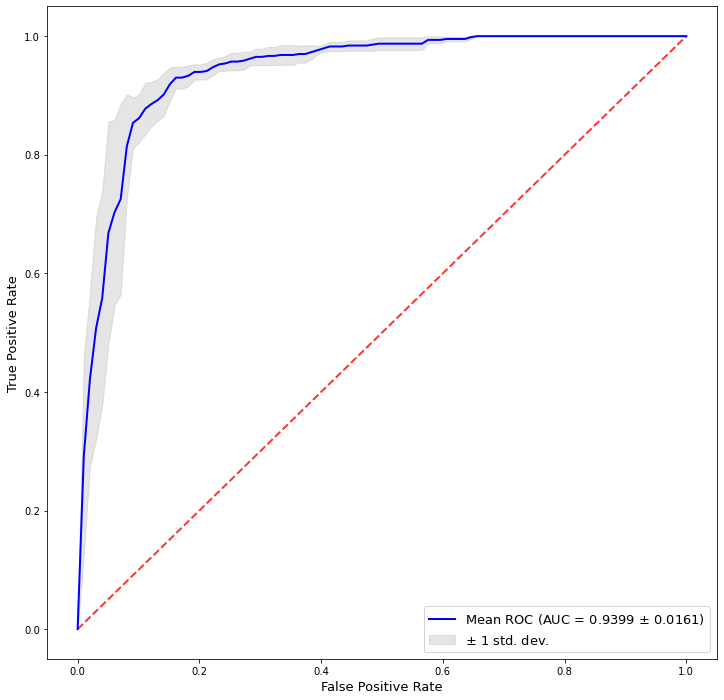

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from scipy import interp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# 初始化模型與變數
model2 = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0, random_state=42)

all_true_labels = np.zeros(len(y))  # 用於儲存所有的真實標籤
all_predictions = np.zeros(len(y))  # 用於儲存所有的預測值
all_probabilities = np.zeros(len(y))  # 用來儲存每筆的 class=1 預測機率

tprs = []
aucs = []
XGBmean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(12, 12))

# 執行交叉驗證
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # 訓練 + 預測機率
    probas_ = model2.fit(X_train, y_train).predict_proba(X_test)

    # 儲存機率與預測值
    all_probabilities[test_idx] = probas_[:, 1]  # 將 class=1 預測機率儲存到對應位置
    test_predictions = model2.predict(X_test).round().flatten()
    all_true_labels[test_idx] = y_test  # 儲存對應的真實標籤
    all_predictions[test_idx] = test_predictions  # 儲存預測結果

    # 畫特徵重要性（permutation importance）
    importances = pd.Series(
        np.mean([permutation_importance(model2, X.iloc[t], y.iloc[t]).importances_mean for _, t in cv.split(X, y)], axis=0),
        index=X.columns
    )
    importances.sort_values(ascending=False, inplace=True)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=importances.values, y=importances.index, edgecolor="black")
    plt.xlabel("Permutation Importance", fontsize=13)
    plt.title(f"Feature Importances - XGB Fold {i+1}", fontsize=13)
    plt.tight_layout()
    plt.show()

    # 計算 ROC 曲線與 AUC
    fpr, tpr, _ = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(XGBmean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # 印出 classification report
    print(f"Classification Report for fold {i+1}:\n{classification_report(y_test, test_predictions, digits=4)}\n")

    # 畫 confusion matrix
    cm = confusion_matrix(y_test, test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix - Fold {i+1}')
    plt.xlabel('Predicted', fontsize=13)
    plt.ylabel('True', fontsize=13)
    plt.show()

# 整體評估
print("Classification Report for All Folds:")
print(classification_report(all_true_labels, all_predictions, digits=4, target_names=['Class 0', 'Class 1']))

# 整體 confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title(f'Confusion Matrix - All Folds')
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('True', fontsize=13)
plt.show()

# 整體 ROC 曲線
plt.figure(figsize=(12, 12))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

XGBmean_tpr = np.mean(tprs, axis=0)
XGBmean_tpr[-1] = 1.0
XGBmean_auc = auc(XGBmean_fpr, XGBmean_tpr)
std_auc = np.std(aucs)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(XGBmean_tpr + std_tpr, 1)
tprs_lower = np.maximum(XGBmean_tpr - std_tpr, 0)

plt.plot(XGBmean_fpr, XGBmean_tpr, color='b', label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (XGBmean_auc, std_auc), lw=2)
plt.fill_between(XGBmean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.legend(loc="lower right", fontsize=13)
plt.show()

# 儲存結果 DataFrame（可轉存 CSV）
results_df = pd.DataFrame({
    "true_label": all_true_labels,
    "predicted_label": all_predictions,
    "predicted_prob": all_probabilities
})
results_df.to_csv("xgb_crossval_results.csv", index=False)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 9, 64)             256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 128)            24704     
                                                                 
 batch_normalization_2 (Batc  (None, 2, 128)           512       
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                      

C:\Users\charl\AppData\Local\Temp\ipykernel_16516\567887303.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0     0.9386    0.9469    0.9427       113
           1     0.9516    0.9440    0.9478       125

    accuracy                         0.9454       238
   macro avg     0.9451    0.9455    0.9453       238
weighted avg     0.9454    0.9454    0.9454       238

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 9, 64)             256       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 2, 128)            24704     
                                                                 
 batch_normalization_6 (Bat

C:\Users\charl\AppData\Local\Temp\ipykernel_16516\567887303.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


Fold 2 Classification Report:
              precision    recall  f1-score   support

           0     0.9035    0.9196    0.9115       112
           1     0.9274    0.9127    0.9200       126

    accuracy                         0.9160       238
   macro avg     0.9155    0.9162    0.9158       238
weighted avg     0.9162    0.9160    0.9160       238

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 9, 64)             256       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 4, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 2, 128)            24704     
                                                                 
 batch_normalization_10 (Ba

C:\Users\charl\AppData\Local\Temp\ipykernel_16516\567887303.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


Fold 3 Classification Report:
              precision    recall  f1-score   support

           0     0.8966    0.9286    0.9123       112
           1     0.9344    0.9048    0.9194       126

    accuracy                         0.9160       238
   macro avg     0.9155    0.9167    0.9158       238
weighted avg     0.9166    0.9160    0.9160       238

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 9, 64)             256       
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 4, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, 2, 128)            24704     
                                                                 
 batch_normalization_14 (Ba

C:\Users\charl\AppData\Local\Temp\ipykernel_16516\567887303.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


Fold 4 Classification Report:
              precision    recall  f1-score   support

           0     0.9009    0.8929    0.8969       112
           1     0.9055    0.9127    0.9091       126

    accuracy                         0.9034       238
   macro avg     0.9032    0.9028    0.9030       238
weighted avg     0.9033    0.9034    0.9033       238

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 9, 64)             256       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 4, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 2, 128)            24704     
                                                                 
 batch_normalization_18 (Ba

C:\Users\charl\AppData\Local\Temp\ipykernel_16516\567887303.py:55: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


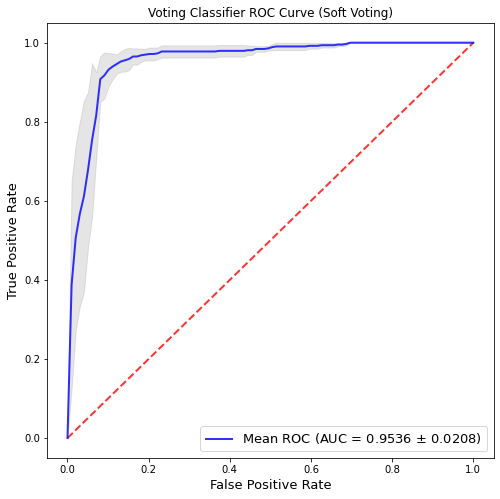

Overall Classification Report:
              precision    recall  f1-score   support

           0     0.9096    0.9144    0.9120       561
           1     0.9233    0.9189    0.9211       629

    accuracy                         0.9168      1190
   macro avg     0.9164    0.9167    0.9166      1190
weighted avg     0.9168    0.9168    0.9168      1190



In [12]:
#5fold 每次重新訓練子模型
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
all_true_labels = []
all_predictions = []
all_probas = []

for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # 重新訓練子模型
    cnnlstm_model = cnnlstm()
    cnnlstm_model.fit(X_train.values.reshape(-1, 11, 1), y_train, epochs=30, batch_size=32, verbose=0)

    knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto', metric='euclidean')
    knn_model.fit(X_train, y_train)

    xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0, random_state=42)
    xgb_model.fit(X_train, y_train)

    # 包 CNNLSTM 成 sklearn compatible (predict_proba)
    wrapped_cnnlstm = KerasClassifier(model=cnnlstm, epochs=30, batch_size=32, verbose=0)
    wrapped_cnnlstm.model_ = cnnlstm_model  # trick，告訴scikeras你已經訓練好了

    # VotingClassifier
    voting_clf = VotingClassifier(
        estimators=[
            ('cnnlstm', wrapped_cnnlstm),
            ('knn', knn_model),
            ('xgb', xgb_model)
        ],
        voting='soft'
    )

    voting_clf.fit(X_train, y_train)

    y_pred = voting_clf.predict(X_test)
    y_prob = voting_clf.predict_proba(X_test)[:, 1]

    all_true_labels.extend(y_test.tolist())
    all_predictions.extend(y_pred.tolist())
    all_probas.extend(y_prob.tolist())

    # 畫ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    print(f"Fold {fold_idx+1} Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))

# 畫平均 ROC
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
         lw=2, alpha=0.8)

plt.fill_between(mean_fpr, np.maximum(mean_tpr - np.std(tprs, axis=0), 0), 
                 np.minimum(mean_tpr + np.std(tprs, axis=0), 1), color='grey', alpha=.2)

plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('Voting Classifier ROC Curve (Soft Voting)')
plt.legend(loc="lower right", fontsize=13)
plt.show()

# 最後全部統計一次
print("Overall Classification Report:")
print(classification_report(all_true_labels, all_predictions, digits=4))


In [13]:
import pandas as pd
import numpy as np

# 讀入三個模型的預測結果
df1 = pd.read_csv("cnn_lstm_predictions.csv")
df2 = pd.read_csv("knn_predictions.csv")
df3 = pd.read_csv("xgb_crossval_results.csv")

# Soft voting：對三個模型預測機率取平均
soft_voting_prob = (df1["predict_label"]+df2["predicted_label"]+ df3["predicted_label"])/3 

# 決策：平均機率 >= 0.5 則判為 class 1，否則為 class 0
soft_voting_pred = ((soft_voting_prob >= 0.5)).astype(int)

true_labels = df1["true_label"]
soft_vote_df = pd.DataFrame({
    "true_label": true_labels,
    "soft_vote_prob": soft_voting_prob,
    "soft_vote_pred": soft_voting_pred
})
print("Classification Report - Soft Voting:\n")
print(classification_report(true_labels, soft_voting_pred, digits=4))

auc_score = roc_auc_score(true_labels, soft_voting_prob)
print(f"ROC AUC (soft voting): {auc_score:.4f}")


Classification Report - Soft Voting:

              precision    recall  f1-score   support

         0.0     0.9417    0.9216    0.9315       561
         1.0     0.9314    0.9491    0.9402       629

    accuracy                         0.9361      1190
   macro avg     0.9365    0.9353    0.9358      1190
weighted avg     0.9362    0.9361    0.9361      1190

ROC AUC (soft voting): 0.9713


In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import interp
import seaborn as sns

# 初始化
all_true_labels = []
all_predictions = []
all_probas = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# 建立交叉驗證
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    print(f"\n[Fold {fold_idx+1}]")
    
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
    
    # 用訓練好的 model 預測機率
    proba1 = model.predict(X_test).ravel()
    proba2 = model1.predict_proba(X_test)[:, 1]
    proba3 = model2.predict_proba(X_test)[:, 1]
    
    # soft voting: 平均三個模型的機率
    avg_proba = (proba1 + proba2 + proba3) / 3
    
    # 取 0.5 當閥值，預測最終類別
    pred_label = (avg_proba >= 0.5).astype(int)

    # 儲存
    all_true_labels.extend(y_test.tolist())
    all_predictions.extend(pred_label.tolist())
    all_probas.extend(avg_proba.tolist())

    # 畫 ROC 曲線
    fpr, tpr, thresholds = roc_curve(y_test, avg_proba)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # 每 fold 的分類報告
    print(classification_report(y_test, pred_label, digits=4))

    # 畫 confusion matrix
    cm = confusion_matrix(y_test, pred_label)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title(f"Confusion Matrix - Fold {fold_idx+1}")
    plt.xlabel('Predicted', fontsize=13)
    plt.ylabel('True', fontsize=13)
    plt.show()

# === 最後總結 ===

print("\n[Overall Result]")
print(classification_report(all_true_labels, all_predictions, digits=4))

# 混淆矩陣
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix - All Folds")
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('True', fontsize=13)
plt.show()

# 平均 ROC 曲線
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color="b",
         label=r"Mean ROC (AUC = %0.4f $\pm$ %0.4f)" % (mean_auc, std_auc),
         lw=2)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2,
                 label=r"$\pm$ 1 std. dev.")

plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('Soft Voting ROC Curve', fontsize=15)
plt.legend(loc="lower right", fontsize=13)
plt.show()

# 輸出結果
df_result = pd.DataFrame({
    "true_label": all_true_labels,
    "predicted_label": all_predictions,
    "predicted_prob": all_probas
})
print(df_result.head(10))

# 可以存成 CSV
df_result.to_csv("soft_voting_predictions.csv", index=False)
